# Mission 2: 배출 규모 가늠하기 - 굴뚝 높이 추정 (Height Estimation from Images)

- 작성자: 인하오남매
- 제출 파일: Mission2.ipynb
- 환경: Google Colab (Python3 + A100 GPU)

## [1] 환경 준비
- Google Drive 마운트
- `requirements.txt` 설치
- 라이브러리 import
- GPU/Device 확인
- Seed 설정

In [2]:
# === (Colab 환경 설정) 한글 폰트 설정 및 캐시 정리 ===
import matplotlib as mpl
print("=== Colab 환경: 한글 폰트 설정 시작 ===")
!apt-get -qq install fonts-nanum
!rm -rf ~/.cache/matplotlib

mpl.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False
print("=== Colab 환경: 한글 폰트 설정 완료 ===")

=== Colab 환경: 한글 폰트 설정 시작 ===
=== Colab 환경: 한글 폰트 설정 완료 ===


In [3]:
# === Google Drive 마운트 ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/M2

/content/drive/MyDrive/M2


In [ ]:
# === requirements.txt 설치 ===
!pip install -r requirements.txt -q

In [5]:
# === 라이브러리 import ===
import os, json, math, random, cv2, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
from torchvision.transforms import functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
# === GPU/Device 설정 ===
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('Using PyTorch:', torch.__version__, '| Device:', DEVICE)

Using PyTorch: 2.8.0+cu126 | Device: cuda


In [7]:
# === Seed 고정 ===
SEED = 42                                  # 난수 고정용 시드값

torch.manual_seed(SEED)                    # PyTorch 난수 시드 고정 (CPU)
np.random.seed(SEED)                       # NumPy 난수 시드 고정
random.seed(SEED)                          # Python random 모듈 시드 고정
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)           # GPU 단일 장치 난수 시드 고정
    torch.cuda.manual_seed_all(SEED)       # 멀티 GPU 환경 난수 시드 고정
torch.backends.cudnn.deterministic = True  # CuDNN 알고리즘을 결정적으로 선택
torch.backends.cudnn.benchmark = False     # 자동 튜닝 비활성화 (재현성 우선)

In [8]:
# === 공용 유틸 ===
def ensure_dir(p: Path) -> Path:
    """
    지정한 경로에 폴더가 없으면 생성하고, Path 객체를 반환하는 함수

    Args:
        p (Path): 생성할 폴더 경로

    Returns:
        p (Path): 생성된(또는 이미 존재하는) 폴더 경로
    """
    p.mkdir(parents=True, exist_ok=True)
    return p

## [2] 데이터 및 결과 저장 폴더 경로 설정
1. 데이터
  - **TS_KS**: 학습용 원본 이미지 전체
  - **VL_KS**: 최종 추론 대상
  - **TL_KS_LINE**: TS_KS 라벨(JSON)
2. 결과 저장 폴더
  - **models**: 체크포인트 저장
  - **figures**: 학습 결과 저장

In [9]:
# === 데이터 경로 설정 ===
PROJECT_ROOT = Path(".")
DATASET_ROOT = PROJECT_ROOT / "data"

# 원본 이미지
IMAGES_TRAIN = DATASET_ROOT / "images" / "TS_KS"
IMAGES_TEST  = DATASET_ROOT / "images" / "VS_KS"

# 라벨
LABELS_TRAIN = DATASET_ROOT / "labels" / "TL_KS_LINE"
LABELS_TEST  = DATASET_ROOT / "labels" / "VL_KS_LINE"

# 전처리 결과 저장 경로
LABELS_TRAIN_CSV = DATASET_ROOT / "labels" / "train_annotations.csv"
MASKS_TRAIN     = DATASET_ROOT / "labels" / "masks"
ensure_dir(MASKS_TRAIN)

PosixPath('data/labels/masks')

In [10]:
# === 결과 저장 경로 ===
MODELS_DIR = PROJECT_ROOT / "models"    # 모델 체크포인트 저장 경로
FIGURES_DIR = PROJECT_ROOT / "figures"  # 시각화 결과/요약 CSV 저장 경로
ensure_dir(MODELS_DIR)
ensure_dir(FIGURES_DIR)

PosixPath('figures')

## [3] 학습 하이퍼파라미터 설정
- 학습 및 추론에 공통 적용되는 파라미터

In [11]:
# === 하이퍼파라미터 설정 ===
BATCH_SIZE = 32      # 미니배치 크기
EPOCHS_STAGE1 = 5    # 1단계: head warm-up 학습 epoch 수
EPOCHS_STAGE2 = 100  # 2단계: full finetune 학습 epoch 수
IMG_SIZE = 224       # 입력 이미지 크기

## [4] 전처리
- 주어진 굴뚝 JSON 어노테이션에서 개별 굴뚝 정보 추출
- 이미지 크기에 맞춰 굴뚝별 마스크(mask) 이미지 생성 및 저장
- 높이값 정규화 후 CSV로 통합 저장
- 주요 함수:
  1) `extract_chimney_info()`: JSON에서 굴뚝 정보 추출
  2) `make_mask()`: 폴리곤 좌표 기반 이진 마스크 생성
  3) `generate_and_save_masks()`: 각 이미지별 마스크 파일 생성
  4) `process_and_save_annotations()`: 전체 파이프라인 실행 및 csv 저장


In [12]:
def extract_chimney_info(json_file_path):
    """
    JSON 파일에서 굴뚝(chimney) 정보를 추출하여 리스트 형태로 반환하는 함수

    Args:
        json_file_path (str or Path):
            굴뚝 주석(annotation) 정보가 담긴 JSON 파일 경로
            각 항목은 이미지 파일명(`filename`)과 여러 굴뚝의 영역 정보(`regions`)를 포함해야 한다.

    Returns:
        list[dict]:
            각 굴뚝의 정보를 담은 딕셔너리들의 리스트. 각 딕셔너리는 다음 키를 포함한다:
            - "original_image_filename" (str): 이미지 파일 이름
            - "chimney_id" (int): 굴뚝 ID
            - "original_height_m" (float): 굴뚝 높이 (미터 단위)
            - "all_points_x" (list[int or float]): 굴뚝 영역의 X좌표 리스트
            - "all_points_y" (list[int or float]): 굴뚝 영역의 Y좌표 리스트
    """
    records = []

    with open(json_file_path, "r", encoding="utf-8") as f:
        annotations = json.load(f)

    for _, meta in annotations.items():
        filename = meta["filename"]

        # 모든 굴뚝 정보 가져오기
        for region in meta.get("regions", []):
            region_attrs = region.get("region_attributes", {})
            shape_attrs = region.get("shape_attributes", {})

            # 필수 정보 추출
            chi_id = region_attrs.get("chi_id")
            height_m = region_attrs.get("chi_height_m")
            all_points_x = shape_attrs.get("all_points_x")
            all_points_y = shape_attrs.get("all_points_y")

            # 굴뚝 높이 float 타입으로 변환
            height_m_float = float(str(height_m).replace(',', '').strip())

            records.append({
                "original_image_filename": filename,
                "chimney_id": int(chi_id),
                "original_height_m": height_m_float,
                "all_points_x": all_points_x,
                "all_points_y": all_points_y
            })

    return records

In [13]:
def make_mask(h, w, poly_x, poly_y):
    """
    주어진 꼭짓점 좌표를 이용해 (H×W) 크기의 이진 마스크(0 또는 255)를 생성하는 함수

    Args:
        h (int):
            출력 마스크의 높이(Height)
        w (int):
            출력 마스크의 너비(Width)
        poly_x (list[int or float]):
            영역의 X축 좌표 리스트 (길이가 2이면 xmin/xmax로 처리)
        poly_y (list[int or float]):
            영역의 Y축 좌표 리스트 (길이가 2이면 ymin/ymax로 처리)

    Returns:
        numpy.ndarray:
            크기 (h, w)의 8비트 단일 채널 이진 마스크 배열
            - 굴뚝 영역 내부는 255로 채워지고, 나머지는 0으로 남는다.
    """
    mask = np.zeros((h, w), dtype=np.uint8)

    if poly_x is None or poly_y is None:
        return mask

    if len(poly_x) == 2 and len(poly_y) == 2:
        x1, x2 = int(min(poly_x)), int(max(poly_x))
        y1, y2 = int(min(poly_y)), int(max(poly_y))
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, thickness=-1)  # 채워진 사각형

    return mask

In [14]:
def generate_and_save_masks(df, original_img_root, mask_root):
    """
    각 굴뚝별로 원본 이미지 크기에 맞는 마스크 이미지를 생성하고,
    지정된 폴더에 PNG 파일로 저장하는 함수

    Args:
        df (pandas.DataFrame):
            굴뚝 주석 정보가 포함된 데이터프레임
            각 행에는 최소한 다음 열이 포함되어야 한다:
            - "original_image_filename": 원본 이미지 파일명
            - "chimney_id": 굴뚝 ID
            - "all_points_x": 굴뚝 영역의 X좌표 리스트(또는 JSON 문자열)
            - "all_points_y": 굴뚝 영역의 Y좌표 리스트(또는 JSON 문자열)
        original_img_root (str or Path):
            원본 이미지들이 위치한 폴더 경로
        mask_root (str or Path):
            생성된 마스크 이미지를 저장할 폴더 경로

    Returns:
        list[str]:
            생성된 마스크 파일들의 파일명 리스트
            각 파일명은 `<원본basename>_<chimney_id>_mask.png` 규칙을 따른다.
    """
    mask_paths = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Generate masks"):
        img_name = row["original_image_filename"]
        chi_id   = row["chimney_id"]

        # 원본 이미지 로드하여 크기 얻기
        img_path = os.path.join(original_img_root, img_name)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        h, w = img.shape[:2]

        # 폴리곤 좌표
        poly_x = json.loads(row["all_points_x"]) if isinstance(row["all_points_x"], str) else row["all_points_x"]
        poly_y = json.loads(row["all_points_y"]) if isinstance(row["all_points_y"], str) else row["all_points_y"]

        mask = make_mask(h, w, poly_x, poly_y)

        base, _ = os.path.splitext(img_name)
        mask_name = f"{base}_{chi_id}_mask.png"
        mask_path = os.path.join(mask_root, mask_name)
        cv2.imwrite(mask_path, mask)   # 0/255 PNG

        mask_paths.append(mask_name)

    return mask_paths

In [15]:
def process_and_save_annotations(train_json_path, original_img_root, mask_root, output_csv):
    """
    주어진 학습용 JSON 주석 파일들을 모두 처리하여,
    굴뚝별 마스크 이미지를 생성하고, 정규화된 높이 정보를 포함한 CSV 파일로 저장하는 함수

    Args:
        train_json_path (str or Path):
            학습용 굴뚝 주석(JSON) 파일들이 위치한 폴더 경로
            각 JSON 파일은 굴뚝 ID, 높이, 좌표 정보 등을 포함해야 한다.
        original_img_root (str or Path):
            원본 이미지 파일들이 위치한 폴더 경로
            마스크 생성 시 이미지 크기를 참조한다.
        mask_root (str or Path):
            생성된 마스크 이미지를 저장할 폴더 경로
            파일명 규칙: `<원본basename>_<chimney_id>_mask.png`
        output_csv (str or Path):
            최종 결과 CSV 파일의 저장 경로
            CSV에는 각 굴뚝의 이미지명, 마스크명, 높이(정규화 포함), 좌표 등이 포함된다.

    Returns:
        pandas.DataFrame:
            생성된 전체 굴뚝 정보를 포함하는 데이터프레임
            주요 컬럼:
            - "image_filename": 원본 이미지 파일명
            - "mask_filename": 생성된 마스크 파일명
            - "original_image_filename": 원본 이미지 파일명
            - "chimney_id": 굴뚝 ID
            - "original_height_m": 원본 높이 (m)
            - "normalized_height": 정규화된 로그 높이 값
            - "all_points_x", "all_points_y": 굴뚝 폴리곤 좌표(JSON 문자열)

    Notes:
        - 높이는 `log1p` 변환 후 z-score 정규화를 적용한다.
        - `generate_and_save_masks()` 함수를 호출하여 각 굴뚝별 마스크를 생성한다.
        - 모든 결과는 지정된 `output_csv` 경로에 저장된다.
    """
    ensure_dir(Path(output_csv).parent)

    # 1. 모든 굴뚝 데이터 수집
    all_records = []
    print("Train 데이터 JSON 파일에서 정보 추출 시작")
    for json_file in tqdm(os.listdir(train_json_path), desc="JSON files"):
        if json_file.endswith(".json"):
            json_file_path = os.path.join(train_json_path, json_file)
            all_records.extend(extract_chimney_info(json_file_path))

    # 2. 높이 정규화 (log1p -> z-score)
    heights = [record["original_height_m"] for record in all_records]
    log_heights = np.log1p(heights)
    log_heights_mean = float(log_heights.mean())
    log_heights_std = float(log_heights.std())
    print(f"로그 변환된 높이 평균: {log_heights_mean:.6f}, 로그 변환된 높이 표준편차: {log_heights_std:.6f}")

    # 3. 정규화 적용
    for record in all_records:
        log_height = math.log1p(record["original_height_m"])
        normalized_height = (log_height - log_heights_mean) / log_heights_std
        record["normalized_height"] = float(normalized_height)
        record["image_filename"] = record["original_image_filename"]

        # CSV 저장을 위해 좌표를 문자열(JSON)로 변환
        record["all_points_x"] = json.dumps(record["all_points_x"])
        record["all_points_y"] = json.dumps(record["all_points_y"])

    # 4. 데이터프레임으로 변환
    df = pd.DataFrame(all_records)

    # 5. 마스크 생성 및 파일명 컬럼 추가
    mask_names = generate_and_save_masks(df, original_img_root, mask_root)
    df["mask_filename"] = mask_names

    # 6. CSV 파일로 저장
    cols = [
        "image_filename", "mask_filename", "original_image_filename", "chimney_id",
        "original_height_m", "normalized_height", "all_points_x", "all_points_y"
    ]
    df[cols].to_csv(output_csv, index=False)
    print(f"\nCSV 저장 완료 → {output_csv}")
    print(f"총 굴뚝 개수: {len(df)}")

## [5] 모델 학습
- 데이터 분할/샘플링
- 정규화/역정규화(타깃 스케일)
- 데이터셋/데이터로더
- 모델/헤드 빌더
- 손실 함수
- 학습 루프
- 캘리브레이션(후처리)
- 평가(EVAL)
- 시각화(Plot)

### [5-1] 데이터 분할/샘플링

In [16]:
# === 데이터 분할 ===
def split_train_val(full_df, val_size=0.1, random_state=SEED, n_bins=10):
    """
    높이 분포 불균형을 완화하기 위해 stratified split을 수행하는 함수

    원본 데이터프레임(full_df)의 'original_height_m' 값을 분위수(qcut) 기반으로
    n_bins개 구간으로 나눈 뒤, 각 구간의 비율을 유지하도록 학습/검증 세트를 분할한다.

    Args:
        full_df (pd.DataFrame): 전체 학습용 데이터프레임
            'original_height_m' 열을 반드시 포함해야 함
        val_size (float, optional): 검증 세트 비율 (기본값=0.1, 즉 9:1 분할)
        random_state (int, optional): 데이터 분할 시 사용할 난수 시드 (기본값=SEED)
        n_bins (int, optional): stratify를 위한 분위수 구간 수 (기본값=10)

    Returns:
        (pd.DataFrame, pd.DataFrame):
            - train_df: 학습용 데이터프레임 (reset_index 완료)
            - val_df: 검증용 데이터프레임 (reset_index 완료)
    """
    # 타깃 분포를 균등 버킷으로 변환
    bins = pd.qcut(full_df['original_height_m'], q=n_bins, duplicates='drop')

    # Train:Val = 9:1
    train_df, val_df = train_test_split(
        full_df, test_size=val_size, random_state=random_state, stratify=bins
    )

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

In [17]:
# === Weighted Sampler 생성 ===
def make_weighted_sampler(train_df, n_bins=10, min_weight=1e-6):
    """
    원본 높이 분포의 불균형을 완화하기 위한 Weighted Sampler를 생성하는 함수

    'original_height_m' 값을 분위수(qcut)로 n_bins개의 구간으로 나눈 뒤,
    각 구간(bin)의 빈도수를 기반으로 역가중치를 부여한다.
    이렇게 생성된 가중치를 이용해 희소 구간(예: 고층 샘플)이
    학습 과정에서 더 자주 샘플링되도록 한다.

    Args:
        train_df (pd.DataFrame): 학습용 데이터프레임
            'original_height_m' 열을 반드시 포함해야 함
        n_bins (int, optional): 높이를 분할할 분위수 구간 수 (기본값=10)
        min_weight (float, optional): 최소 가중치 하한값 (기본값=1e-6)

    Returns:
        torch.utils.data.WeightedRandomSampler:
            각 샘플의 가중치가 반영된 PyTorch WeightedRandomSampler 객체
            epoch마다 전체 샘플 길이(len(weights))만큼 샘플링하며,
            교체(replacement=True) 방식으로 동작함
    """
		# 높이를 분위수 기반으로 n_bins개 구간으로 나눔
    bins = pd.qcut(train_df['original_height_m'], q=n_bins, duplicates='drop')

    # 각 구간(bin)별 샘플 개수 세기
    bin_counts = bins.value_counts().to_dict()

    # 각 샘플의 가중치 = 해당 bin에 속한 샘플 개수의 역수
    w_np = bins.map(lambda b: 1.0 / bin_counts[b]).to_numpy()
    weights = torch.as_tensor(w_np, dtype=torch.double)

    # WeightedRandomSampler 객체 생성
    return torch.utils.data.WeightedRandomSampler(
        weights=weights,
        num_samples=len(weights),  # epoch마다 전체 길이와 동일
        replacement=True
    )

### [5-2] 정규화/역정규화

In [18]:
# === 정규화/역정규화 유틸 ===
def get_log_stats(df):
    """
    높이(m) 값을 log1p 스케일로 변환했을 때의 평균과 표준편차를 계산하는 함수

    학습 타깃은 (log1p(height) - mean) / std 형태로 정규화되며,
    본 함수는 그에 필요한 log1p 변환된 평균과 표준편차를 반환한다.

    Args:
        df (pd.DataFrame): 높이 데이터를 포함한 데이터프레임
            'original_height_m' 열을 반드시 포함해야 함

    Returns:
        tuple(float, float):
            - log_mean: log1p(height)의 평균값
            - log_std: log1p(height)의 표준편차
    """
    logh = np.log1p(df["original_height_m"].values)
    return float(logh.mean()), float(logh.std())

In [19]:
def inv_norm_to_m(x_norm, log_mean, log_std):
    """
    정규화된 예측값(또는 라벨값)을 실제 높이(m) 단위로 역변환하는 함수

    (x_norm * std + mean)을 통해 log1p 스케일을 복원한 뒤,
    expm1 연산으로 log1p를 되돌려 실제 단위로 변환한다.

    Args:
        x_norm (np.ndarray or float): 정규화된 값 (예측 또는 라벨)
        log_mean (float): log1p(height)의 평균값
        log_std (float): log1p(height)의 표준편차

    Returns:
        np.ndarray or float: 실제 높이 단위(m)로 복원된 값
    """
    x_log = x_norm * log_std + log_mean
    return np.expm1(x_log)

In [20]:
def inv_norm_to_m_torch(x_norm, log_mean, log_std):
    """
    정규화된 값을 torch 연산으로 실제 높이(m) 단위로 역변환하는 함수
    GPU 연산 및 역전파(gradient)를 안전하게 수행할 수 있다.

    Args:
        x_norm (torch.Tensor): 정규화된 높이 텐서 (모델 출력 또는 타깃)
        log_mean (float): log1p(height)의 평균값
        log_std (float): log1p(height)의 표준편차

    Returns:
        torch.Tensor: 실제 높이 단위(m)로 복원된 텐서
    """
    x_log = x_norm * log_std + log_mean
    return torch.expm1(x_log)

### [5-3] 데이터셋/데이터로더

In [21]:
# === 데이터셋 정의 ===
class ChimneyMaskDataset(Dataset):
    """
    굴뚝 높이 예측을 위한 커스텀 PyTorch Dataset 클래스

    각 샘플은 RGB 3채널 원본 이미지와 대응되는 soft mask(1채널)를 결합하여
    4채널 입력 텐서 (4, H, W)를 구성한다.
    타깃(label)은 log1p → z-score 형태로 정규화된 굴뚝 높이 값이다.

    학습 단계에서는 약한 기하 증강(수평 뒤집기, ±7° 회전)을 적용하며,
    RGB 채널은 ImageNet 통계(mean/std) 기준으로 정규화한다.

    Args:
        df (pd.DataFrame): 이미지/마스크/타깃 정보를 포함한 데이터프레임
            'image_filename', 'mask_filename', 'normalized_height' 열을 포함해야 함
        img_dir (str or Path): 원본 이미지가 저장된 폴더 경로
        mask_dir (str or Path): 마스크 이미지가 저장된 폴더 경로
        img_size (int, optional): 리사이즈할 정사각 이미지 크기 (기본값=224)
        is_train (bool, optional): 학습 여부 (True일 경우 데이터 증강 활성화, 기본값=True)

    Returns:
        tuple(torch.Tensor, torch.Tensor):
            - x (torch.Tensor): 4채널 입력 텐서 (shape: [4, H, W])
            - y (torch.Tensor): 정규화된 높이 스칼라 (shape: [])
    """
    def __init__(self, df, img_dir, mask_dir, img_size=224, is_train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.is_train = is_train
        self.img_size = img_size

        # ImageNet 분포에 맞춘 정규화 (EfficientNet 백본 호환)
        self.mean = [0.485, 0.456, 0.406]
        self.std  = [0.229, 0.224, 0.225]
        self.normalize = transforms.Normalize(mean=self.mean, std=self.std)

    def __len__(self):
        return len(self.df)

    def _load_image(self, path):
        """ RGB 이미지 로드 및 채널 변환 """
        with Image.open(path) as im:
            return im.convert("RGB")

    def _load_mask(self, path):
        """ 마스크 로드 및 단일 채널(L) 변환 """
        m = Image.open(path).convert("L")
        return m

    def __getitem__(self, idx):
        # --- 파일 경로 조회 ---
        row = self.df.iloc[idx]
        img_path  = os.path.join(self.img_dir, row["image_filename"])
        mask_path = os.path.join(self.mask_dir, row["mask_filename"])

        # --- 이미지/마스크 로드 ---
        img  = self._load_image(img_path)
        mask = self._load_mask(mask_path)

        # --- 공통 리사이즈 (소프트마스크 보존) ---
        img  = F.resize(img,  (self.img_size, self.img_size), interpolation=InterpolationMode.BILINEAR)
        mask = F.resize(mask, (self.img_size, self.img_size), interpolation=InterpolationMode.BILINEAR)

        # --- 이미지/마스크 동기화 증강 (Train만 적용) ---
        if self.is_train:
            if random.random() < 0.3:          # 수평 뒤집기
                img  = F.hflip(img)
                mask = F.hflip(mask)
            angle = random.uniform(-7.0, 7.0)  # 회전
            img  = F.rotate(img,  angle, interpolation=InterpolationMode.BILINEAR, fill=0)
            mask = F.rotate(mask, angle, interpolation=InterpolationMode.BILINEAR, fill=0)

        # --- 텐서 변환 및 정규화 ---
        x = F.to_tensor(img)   # (3,H,W)
        x = self.normalize(x)  # RGB만 정규화

        # --- 마스크 추가 → 4채널 입력 구성 ---
        mask_t = F.to_tensor(mask)              # (1,H,W), 0~1
        out = torch.cat([x, mask_t], dim=0)     # (4,H,W)

        # --- 타깃(label): 정규화된 높이 ---
        y = torch.tensor(row["normalized_height"], dtype=torch.float32)

        return out, y

In [22]:
# === 데이터로더 ===
def make_dataloaders(df_train, df_val, batch_size=BATCH_SIZE):
    """
    학습/검증용 PyTorch DataLoader를 생성하는 함수

    - Train 로더: 높이 분포 불균형을 완화하기 위해 WeightedRandomSampler 사용
    - Val 로더  : 순차적 배치(shuffle=False)
    - 재현성    : torch.Generator + worker_init_fn로 셔플/워커 난수 고정
    - I/O 튜닝 : num_workers, pin_memory, prefetch_factor, persistent_workers 설정

    Args:
        df_train (pd.DataFrame):
            학습용 데이터프레임. ChimneyMaskDataset이 요구하는
            'image_filename', 'mask_filename', 'normalized_height' 컬럼을 포함해야 한다.
        df_val (pd.DataFrame):
            검증용 데이터프레임. 컬럼 요건은 df_train과 동일하다.
        batch_size (int, optional):
            미니배치 크기. 기본값은 전역 상수 BATCH_SIZE를 따른다.

    Returns:
        tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
            - train_loader: WeightedRandomSampler 기반 학습용 DataLoader
            - val_loader  : 순차 로딩 검증용 DataLoader

    Notes:
        - 전역/외부 의존: ORIG_IMG_DIR, MASK_DIR, IMG_SIZE, SEED,
          ChimneyMaskDataset, make_weighted_sampler, torch.cuda.is_available().
        - 분포 불균형이 심한 경우 sampler가 효과적이며, drop_last=True로
          배치 정렬(특히 BN/AMP 사용 시) 안정성을 높인다.
    """
    # --- Dataset 구성 ---
    train_ds = ChimneyMaskDataset(df_train, IMAGES_TRAIN, MASKS_TRAIN,
                                  img_size=IMG_SIZE, is_train=True)   # 학습용
    val_ds   = ChimneyMaskDataset(df_val,   IMAGES_TRAIN, MASKS_TRAIN,
                                  img_size=IMG_SIZE, is_train=False)  # 검증용

    # --- Weighted Sampler 생성 ---
    sampler = make_weighted_sampler(df_train, n_bins=10)

    # --- 시드 고정용 Generator & Worker Init ---
    g = torch.Generator(); g.manual_seed(SEED)
    def seed_worker(worker_id):
        np.random.seed(SEED + worker_id)
        random.seed(SEED + worker_id)

    # --- DataLoader ---
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,                         # shuffle 대신 sampler 적용
        num_workers=8,                           # GPU I/O 병렬 처리 최적화
        pin_memory=torch.cuda.is_available(),    # GPU 전송 속도 최적화
        persistent_workers=True,                 # epoch 간 워커 재사용
        prefetch_factor=4,                       # 워커당 미리 적재할 배치 수
        drop_last=True,                          # 마지막 불완전 배치 드롭
        worker_init_fn=seed_worker,
        generator=g
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,                           # 검증은 순차적
        num_workers=8,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=True,
        prefetch_factor=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    return train_loader, val_loader

### [5-4] 모델/헤드 빌더

In [23]:
# === 모델: EfficientNet-B0 + 회귀 해드 ===
class RegressorHead(nn.Module):
    """
    분류용 헤드를 제거한 백본의 임베딩 벡터를 입력받아,
    굴뚝 높이(스칼라)를 예측하는 회귀 전용 MLP 헤드
    Dropout을 단계적으로 적용해 과적합을 억제한다.

    Args:
        in_features (int): 백본이 출력하는 임베딩 벡터의 차원 수
        dropout (float, optional): 각 드롭아웃 레이어의 드롭 비율. 기본값은 0.3

    Returns:
        torch.Tensor:
            forward 호출 시 (B,) 형태의 1차원 회귀 출력 텐서를 반환한다.
    """
    def __init__(self, in_features, dropout=0.3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): (B, in_features) 형태의 백본 임베딩 벡터

        Returns:
            torch.Tensor: (B,) 형태의 회귀 스칼라 출력
        """
        return self.mlp(x).squeeze(-1)  # (batch, in_features) → (batch,)

In [24]:
def build_efficientnet_b0_4ch(dropout=0.3):
    """
    EfficientNet-B0 백본을 사용해 **RGB+Mask 4채널 입력**을 처리하는 회귀 모델을 생성하는 함수

    동작 요약:
    - 입력 4채널(B, 4, H, W)을 `1×1 Conv`로 3채널로 축소해 ImageNet 사전학습 백본과 호환
    - EfficientNet-B0의 분류 헤드를 제거하고, `RegressorHead`(MLP)로 교체
    - 출력은 스칼라 회귀값 (굴뚝 높이 등)

    Args:
        dropout (float, optional):
            회귀 헤드(MLP)에 적용할 드롭아웃 비율. 기본값 0.3

    Returns:
        torch.nn.Module:
            다음 하위 모듈을 갖는 모델 인스턴스
            - `reduce4to3`: `nn.Conv2d(4→3, kernel_size=1)` — 4채널 입력을 3채널로 축소
            - `backbone`: EfficientNet-B0 (classifier가 `Identity`로 교체됨)
            - `head`: `RegressorHead(in_features, dropout)`
            forward 입력/출력:
            - 입력: `x` (torch.Tensor, shape: [B, 4, H, W])
            - 출력: 회귀 스칼라 (torch.Tensor, shape: [B])

    Notes:
        - 백본 가중치: `models.EfficientNet_B0_Weights.IMAGENET1K_V1` 사전학습 사용
        - 학습 시 4채널 입력의 scale/정규화를 백본 사전학습 분포(ImageNet mean/std)에 맞추려면,
          1×1 Conv 앞에서가 아니라 **RGB 3채널**에만 정규화를 적용하는 것을 권장한다.
          (Mask 채널은 그대로 concat 후 1×1 Conv로 축소)
    """
    # --- 1. EfficientNet-B0의 백본 (ImageNet 사전학습) ---
    backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    # --- 2. 4채널 입력 → 3채널 변환 (mask + RGB 통합) by 1x1 convolution ---
    reduce4to3 = nn.Conv2d(4, 3, kernel_size=1, bias=False)

    # --- 3. 기존 분류 헤드 제거 (feature 백본만 사용) ---
    in_feats = backbone.classifier[1].in_features                # 백본 최종 벡터 차원
    backbone.classifier = nn.Identity()                          # 분류 헤드 제거

    # --- 4. 회귀 헤드 추가 ---
    head = RegressorHead(in_features=in_feats, dropout=dropout)

    # --- 5. 전체 모델 구성 ---
    class EfficientNetReg(nn.Module):
        def __init__(self, backbone, head, reduce4to3):
            super().__init__()
            self.reduce4to3 = reduce4to3
            self.backbone = backbone
            self.head = head

        def forward(self, x):         # 입력: (B, 4, H, W)
            x = self.reduce4to3(x)    # 4채널 → 3채널
            feats = self.backbone(x)  # 특징 벡터 추출

            return self.head(feats)   # 회귀값 출력 (B,)

    return EfficientNetReg(backbone, head, reduce4to3)

### [5-5] 손실 함수

In [25]:
class HeightAwareLoss(nn.Module):
    """
    높이(미터) 기준 상위 구간을 더 강조하는 sigmoid 고정 Huber 기반 손실 함수

    기본 손실로 SmoothL1(Huber)을 사용하고, 미터 단위 참조값(ref_m)의
    분위수 임계값(thr)을 기준으로 시그모이드 가중치 w(h)을 곱한다.

    Args:
        log_mean (float): 타깃 정규화에 사용된 log1p(height)의 평균
        log_std (float): 타깃 정규화에 사용된 log1p(height)의 표준편차
        delta (float, optional): Huber(SmoothL1) 손실의 beta(=delta). 기본값 0.3
        q (float, optional): 분위수 q (예: 0.80 → 상위 20%를 고층으로 간주). 기본값 0.80
        alpha (float, optional): 고층 강조 강도 (1.0이면 가중치 1로 효과 없음). 기본값 1.5
        scale (float, optional): 시그모이드 입력 스케일(온도). 기본값 60.0
        clip (tuple[float|None, float|None] | None, optional):
            (w_min, w_max) 형태의 가중치 하/상한. None 허용. 기본값 (1.0, None)
        q_source (str, optional): 분위수 계산 기준. {"target", "pred"} 중 하나. 기본값 "target"

    Inputs:
        pred_norm (torch.Tensor): 정규화된 예측값 (log1p z-score), shape: (N,) 또는 (N,1)
        target_norm (torch.Tensor): 정규화된 타깃값 (log1p z-score), shape: pred_norm과 동일

    Returns:
        torch.Tensor: 스칼라 손실 값 (배치 평균)
    """

    def __init__(self, log_mean, log_std, *, delta=0.3, q=0.80,
                 alpha=2.0, scale=60.0, clip=(1.0, None), q_source="target"):
        super().__init__()
        self.log_mean = float(log_mean)
        self.log_std  = float(log_std)
        self.delta    = delta
        self.q        = float(q)
        self.alpha    = float(alpha)
        self.scale    = float(scale)
        self.clip     = clip
        self.q_source = q_source

        self.base_loss = nn.SmoothL1Loss(beta=self.delta, reduction="none")

    @torch.no_grad()
    def _compute_thr(self, ref_m):
        """미터 단위(ref_m)에서 분위수 q 임계값(thr)을 계산"""
        return torch.quantile(ref_m, torch.tensor(self.q, device=ref_m.device))

    def _weights_sigmoid(self, ref_m, thr):
        """sigmoid 모드로 가중치 계산"""
        z = (ref_m - thr) / self.scale
        w = 1.0 + self.alpha * torch.sigmoid(z)

        # 안전 캡(하/상한)
        wmin = 1.0 if self.clip is None else (1.0 if self.clip[0] is None else self.clip[0])
        wmax = None if self.clip is None else self.clip[1]
        return torch.clamp(w, wmin, wmax) if wmax is not None else torch.clamp_min(w, wmin)

    def forward(self, pred_norm, target_norm):
        """
        1) base = SmoothL1(pred_norm, target_norm)  (reduction="none")
        2) ref = target_norm(혹은 pred_norm, q_source에 따름)
        3) ref를 미터 단위로 역변환 → 분위수 임계값 thr 도출
        4) 시그모이드 가중치 w 계산
        5) (base * w).mean() 반환
        """
        base = self.base_loss(pred_norm, target_norm)

        with torch.no_grad():
            ref   = target_norm if self.q_source == "target" else pred_norm
            ref_m = inv_norm_to_m_torch(ref, self.log_mean, self.log_std)
            thr   = self._compute_thr(ref_m)

        w = self._weights_sigmoid(ref_m, thr).to(base.dtype)
        return (base * w).mean()

### [5-6] 학습 루프

In [26]:
def train_two_stage(train_loader, val_loader, model, epochs_stage1=5, epochs_stage2=100,
                    lr_head=1e-3, lr_full=1e-4, weight_decay=1e-4,
                    log_mean=None, log_std=None, *, delta=0.3,
                    q=0.80, alpha=2.0, scale=60.0,
                    clip=(1.0, 3.0), q_source="target",
                    save_tag_base=None, save_dir=MODELS_DIR):
    """
    두 단계 학습 루틴:
      - Stage 1 (Head Warm-up): 백본 고정(freeze), reduce4to3 + head만 HuberLoss로 학습
      - Stage 2 (Full Finetune): 전체 가중치 학습, sigmoid 고정 Height-aware Huber 손실로 훈련
        검증 시에는 MSE 손실을 로깅하고, 실제 단위(m) 기준 RMSE로 Best를 선정하여 체크포인트 저장

    Args:
        train_loader (torch.utils.data.DataLoader):
            학습용 DataLoader
        val_loader (torch.utils.data.DataLoader):
            검증용 DataLoader
        model (torch.nn.Module):
            학습할 네트워크. 속성으로 `backbone`, `reduce4to3`, `head`를 가진 구조를 가정
        epochs_stage1 (int, optional):
            Stage 1(헤드 워밍업) epoch 수. 기본 5
        epochs_stage2 (int, optional):
            Stage 2(풀 파인튜닝) epoch 수. 기본 100
        lr_head (float, optional):
            Stage 1에서 head/reduce4to3 학습 시 learning rate. 기본 1e-3
        lr_full (float, optional):
            Stage 2에서 전체 파라미터 학습 시 learning rate. 기본 1e-4
        weight_decay (float, optional):
            AdamW weight decay. 기본 1e-4
        log_mean (float):
            타깃 정규화에 사용된 log1p(height) 평균
        log_std (float):
            타깃 정규화에 사용된 log1p(height) 표준편차
        delta (float, optional):
            Huber(SmoothL1) beta(=delta). 기본 0.3
        q (float, optional):
            Height-aware 가중에 사용할 분위수 q (예: 0.80). 기본 0.80
        alpha (float, optional):
            Height-aware 가중 강도(1.0이면 효과 없음). 기본 1.5
        scale (float, optional):
            Height-aware 시그모이드 스케일(온도). 기본 60.0
        clip (tuple[float|None, float|None], optional):
            (w_min, w_max) 가중치 하/상한. 기본 (1.0, None)
        q_source (str, optional):
            분위수 계산 기준 {"target","pred"}. 기본 "target"
        save_tag_base (str | None, optional):
            베스트 RMSE 기준 체크포인트 파일명 접두사. None이면 저장하지 않음
        save_dir (str, optional):
            체크포인트 저장 폴더.

    Returns:
        tuple[float, list[float], list[float], str | None]:
            - best_rmse (float): Stage 2 진행 중 기록한 최소 RMSE(m)
            - hist_train (list[float]): epoch별 학습 손실(Height-aware Huber) 기록
            - hist_val (list[float]): epoch별 검증 손실(MSE) 기록
            - best_rmse_ckpt (str | None): 베스트 체크포인트 경로 (저장 안 했으면 None)
    """
    model = model.to(DEVICE)

    # --- 손실 함수 세팅 --- (추가)
    criterion_stage1_train = nn.SmoothL1Loss(beta=delta)   # Stage 1: HuberLoss
    criterion_stage2_train = HeightAwareLoss(              # Stage 2: Height-aware Loss
        log_mean=log_mean, log_std=log_std,
        delta=delta, q=q, alpha=alpha, scale=scale,
        clip=clip, q_source=q_source
    )
    criterion_val_mse = nn.MSELoss()                       # 검증: MSELoss

    # --- Stage 1: Head Warm-up ---
    for p in model.backbone.parameters(): p.requires_grad = False   # freeze backbone
    for p in model.reduce4to3.parameters(): p.requires_grad = True
    for p in model.head.parameters():      p.requires_grad = True

    # Optimizer 설정
    optimizer = optim.AdamW(
        list(model.head.parameters()) + list(model.reduce4to3.parameters()),
        lr=lr_head, weight_decay=weight_decay
    )

    # Stage 1 epoch 반복
    for ep in range(epochs_stage1):
        model.train()
        total = 0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)   # 그래디언트 초기화
            pred = model(x)                         # 순전파
            loss = criterion_stage1_train(pred, y)  # Huber 손실 계산 (변경)
            loss.backward()                         # 역전파
            optimizer.step()                        # 파라미터 업데이트
            total += loss.item()                    # 손실 누적
        print(f"[Stage1] Epoch {ep+1}/{epochs_stage1} - Train Loss HUBER {total/len(train_loader):.4f}")

    # --- Stage 2: Full Fine-tuning ---
    for p in model.parameters(): p.requires_grad = True  # unfreeze

    # Optimizer 설정 (더 작은 학습률로 전체 미세조정)
    optimizer = optim.AdamW(model.parameters(), lr=lr_full, weight_decay=weight_decay)

    # 베스트 모델 저장을 위한 상태 변수
    best_rmse = float('inf')  # 최소 RMSE(m)
    best_rmse_ckpt = None     # 최소 RMSE 달성 시 저장된 체크포인트 경로

    # 학습/검증 손실 히스토리(플롯용)
    hist_train, hist_val = [], []

    # Stage 2 epoch 반복
    for ep in range(epochs_stage2):
        # 1. Train (Huber)
        model.train()
        ttotal = 0.0

        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            pred = model(x)
            loss = criterion_stage2_train(pred, y)
            loss.backward()
            optimizer.step()
            ttotal += loss.item()
        tr = ttotal/len(train_loader)

        # 2. Val (MSE)
        model.eval()
        vtotal_mse = 0.0

        with torch.no_grad():  # 검증 시에는 그래디언트 추적 불필요
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x)
                vtotal_mse += criterion_val_mse(pred, y).item()  # MSE 손실 계산
        va_mse = vtotal_mse/len(val_loader)

        # 히스토리 업데이트(플롯용)
        hist_train.append(tr)
        hist_val.append(va_mse)

        # 실제 단위(meter) 기준 지표 계산
        _, _, rmse_m, mae_m, r2_m = eval_in_meters(model, val_loader, log_mean, log_std)

        print(
          f"[Stage2] Epoch {ep+1}/{epochs_stage2} - "
          f"Train Loss Height-aware(Huber) {tr:.4f} | "
          f"Val Loss MSE {va_mse:.4f} | "
          f"Val(m): RMSE {rmse_m:.2f}m, MAE {mae_m:.2f}m, R² {r2_m:.4f}"
        )

        # Best-by-RMSE(meter) 체크포인트 저장
        if rmse_m < best_rmse and save_tag_base is not None:
            best_rmse = rmse_m
            best_rmse_ckpt = os.path.join(save_dir, f"{save_tag_base}_best_by_rmse.pth")
            torch.save(model.state_dict(), best_rmse_ckpt)
            print(f"  ↳ [Save] New best RMSE {best_rmse:.2f}m -> {best_rmse_ckpt}")

    return best_rmse, hist_train, hist_val, best_rmse_ckpt

### [5-7] 캘리브레이션(후처리)

In [27]:
@dataclass
class CalibParams:
    """
    선형 보정(calibration) 설정값 컨테이너

    Attributes:
        mode (str): 보정 모드. {"quantile", "identity"} 중 하나
            - "quantile": 예측 상위 구간(H_TH 이상)에만 선형 보정 a*x + b 적용
            - "identity": 보정 미적용(항등)
        H_TH (float): 보정 적용 임계값(미터). y >= H_TH인 값에만 보정 적용
        a (float): 선형 보정의 기울기
        b (float): 선형 보정의 절편
        quantile (float | None): 분위수 기반 임계값을 썼을 때의 q 값 기록(예: 0.80)
        clip_min (float): 보정 후 예측값 하한(미터)
        clip_max (float): 보정 후 예측값 상한(미터)
        min_samples (int): 분위수 영역에서 최소 필요 샘플 수(보정 신뢰성 가드레일)
    """
    mode: str
    H_TH: float                 # 임계값(미터)
    a: float                    # 기울기
    b: float                    # 절편
    quantile: float|None = None
    clip_min: float = 30.0
    clip_max: float = 320.0
    min_samples: int = 50

def _fit_linear(x: np.ndarray, y: np.ndarray):
    """
    최소제곱으로 y ≈ a*x + b 선형식을 피팅하고, 안정성을 위한 가드레일로 계수를 클리핑하는 함수

    Args:
        x (np.ndarray): 입력 값 (예측값 등), shape: (N,)
        y (np.ndarray): 타깃 값 (실측값 등), shape: (N,)

    Returns:
        tuple[float, float]:
            - a: 기울기(0.8~1.4 범위로 클리핑)
            - b: 절편(-40.0~40.0 범위로 클리핑)
    """
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    a = float(np.clip(a, 0.8, 1.4))
    b = float(np.clip(b, -40.0, 40.0))
    return a, b

def apply_calibration(y_pred_m: np.ndarray, C: CalibParams) -> np.ndarray:
    """
    임계값(H_TH) 이상 구간에만 선형 보정 a*x + b를 적용하고, 결과를 지정 범위로 클리핑하는 함수

    Args:
        y_pred_m (np.ndarray): 예측 높이 값(미터), shape: (N,)
        C (CalibParams): 보정 파라미터(모드, 임계값, 선형계수, 클리핑 범위 등)

    Returns:
        np.ndarray: 보정 및 클리핑이 적용된 예측 값(미터), shape: (N,)
    """
    y = y_pred_m.astype(np.float64).copy()
    hi = y >= C.H_TH
    y[hi] = C.a * y[hi] + C.b
    return np.clip(y, C.clip_min, C.clip_max)

In [28]:
def _rmse(a: np.ndarray, b: np.ndarray) -> float:
    """
    RMSE(Root Mean Squared Error)를 계산합니다.

    Args:
        a (np.ndarray): 값 배열 A, shape: (N,)
        b (np.ndarray): 값 배열 B, shape: (N,)

    Returns:
        float: RMSE 값
    """
    return float(np.sqrt(np.mean((a - b) ** 2)))


def _mae(a: np.ndarray, b: np.ndarray) -> float:
    """
    MAE(Mean Absolute Error)를 계산합니다.

    Args:
        a (np.ndarray): 값 배열 A, shape: (N,)
        b (np.ndarray): 값 배열 B, shape: (N,)

    Returns:
        float: MAE 값
    """
    return float(np.mean(np.abs(a - b)))

In [29]:
def fit_and_eval_calibration_quantile(
    preds_m, targs_m, *, q=0.80,
    clip_min=30.0, clip_max=320.0, min_samples=50
):
    """
    예측값 상위 q 분위수 구간에만 선형 보정( a*x + b )을 적용하도록
    보정 계수(a, b)와 임계값(H_TH)을 추정하고, 보정 전/후 성능을 평가하는 함수

    절차:
      1) 원본 성능 계산 (RMSE/MAE, 미터 단위)
      2) 예측값의 q 분위수(H_TH)를 임계값으로 선정
      3) preds_m ≥ H_TH 영역에서 최소제곱으로 a, b 피팅 (가드레일 포함)
      4) 해당 보정을 전체 예측에 적용(임계 이상 구간만) + 클리핑
      5) 보정 후 RMSE/MAE 계산 및 결과 반환

    Args:
        preds_m (np.ndarray): 예측 높이 (미터), shape: (N,)
        targs_m (np.ndarray): 실제 높이 (미터), shape: (N,)
        q (float, optional): 분위수 임계값. 예: 0.80 → 상위 20%만 보정. 기본 0.80
        clip_min (float, optional): 보정/클리핑 후 하한값(미터). 기본 30.0
        clip_max (float, optional): 보정/클리핑 후 상한값(미터). 기본 320.0
        min_samples (int, optional): 보정 영역 내 최소 필요 샘플 수. 부족 시 보정 생략. 기본 50

    Returns:
        tuple[CalibParams, float, float, float, float]:
            - Cq (CalibParams): 추정된 보정 파라미터(모드="quantile" 또는 "identity")
            - base_rmse (float): 보정 전 RMSE (m)
            - base_mae  (float): 보정 전 MAE  (m)
            - rmse_best (float): 보정 후 RMSE (m)
            - mae_best  (float): 보정 후 MAE  (m)
    """
    # 원본 성능
    base_rmse = mean_squared_error(targs_m, preds_m) ** 0.5
    base_mae  = np.mean(np.abs(targs_m - preds_m))

    # 기준 A) 분위수
    Hq = float(np.quantile(preds_m, q))
    mask_q = preds_m >= Hq
    if mask_q.sum() < min_samples:
        print(f"[Calib] Skip quantile(q={q}) : samples={mask_q.sum()} < {min_samples}")
        Cid = CalibParams(mode="identity", H_TH=1e9, a=1.0, b=0.0,
                          clip_min=clip_min, clip_max=clip_max, min_samples=min_samples)
        return Cid, base_rmse, base_mae, base_rmse, base_mae

    # 분위수 구간에서 선형 보정 계수 추정
    a, b = _fit_linear(preds_m[mask_q], targs_m[mask_q])
    Cq = CalibParams(mode="quantile", H_TH=Hq, a=a, b=b, quantile=q,
                     clip_min=clip_min, clip_max=clip_max, min_samples=min_samples)

    # 보정 적용
    preds_cal_q = apply_calibration(preds_m, Cq)
    rmse_best = mean_squared_error(targs_m, preds_cal_q) ** 0.5
    mae_best  = np.mean(np.abs(targs_m - preds_cal_q))

    print(f"[Calib-Q{q}] Base RMSE={base_rmse:.2f}m / MAE={base_mae:.2f}m")
    print(f"[Calib-Q{q}] H_TH={Cq.H_TH:.2f}m  a={Cq.a:.3f}, b={Cq.b:.2f}")
    print(f"[Calib-Q{q}] Overall RMSE: {base_rmse:.2f}m → {rmse_best:.2f}m, "
          f"MAE: {base_mae:.2f}m → {mae_best:.2f}m")

    return Cq, base_rmse, base_mae, rmse_best, mae_best

### [5-8] 평가 및 시각화

In [30]:
# === 평가 함수 (미터 단위) ===)
def eval_in_meters(model, val_loader, log_mean, log_std):
    """
    검증 로더에 대해 모델 예측을 수집하고, 정규화 스케일에서 실제 높이(m) 단위로
    역변환한 뒤 RMSE/MAE/R² 지표를 계산하는 함수

    Args:
        model (torch.nn.Module):
            평가할 모델. forward(x) → 정규화된 스칼라 예측(배치)을 반환해야 한다.
        val_loader (torch.utils.data.DataLoader):
            (입력, 정규화된 타깃) 배치를 제공하는 검증용 데이터로더
        log_mean (float):
            타깃 정규화에 사용된 log1p(height)의 평균값
        log_std (float):
            타깃 정규화에 사용된 log1p(height)의 표준편차

    Returns:
        tuple[np.ndarray, np.ndarray, float, float, float]:
            - preds_m: 예측값(미터) 배열, shape (N,)
            - targs_m: 정답값(미터) 배열, shape (N,)
            - rmse   : RMSE (미터)
            - mae    : MAE  (미터)
            - r2     : R² 스코어
    """
    model.eval()
    preds_norm, targs_norm = [], []

    with torch.no_grad():  # 평가 시 그래디언트 추적 불필요
        for x, y in val_loader:
            x = x.to(DEVICE)

            # 모델 예측
            pred = model(x).detach().cpu().numpy()
            preds_norm.append(pred)

            targs_norm.append(y.numpy())

    # 미니배치별 배열을 하나로 합치기
    preds_norm = np.concatenate(preds_norm)
    targs_norm = np.concatenate(targs_norm)

    # 정규화 스케일 → 실제 미터(m)로 역변환
    preds_m = inv_norm_to_m(preds_norm, log_mean, log_std)
    targs_m = inv_norm_to_m(targs_norm, log_mean, log_std)

    # 지표 계산 (모두 미터 단위)
    rmse = mean_squared_error(targs_m, preds_m) ** 0.5
    mae  = np.mean(np.abs(targs_m - preds_m))
    r2   = r2_score(targs_m, preds_m)

    return preds_m, targs_m, rmse, mae, r2

In [31]:
# === 시각화 유틸 1. 학습 곡선 ===
def plot_training_curves(train_hist, val_hist, title, save_path):
    """
    학습/검증 손실의 Epoch별 변화를 선 그래프로 시각화하고 파일로 저장하는 함수

    Args:
        train_hist (list[float] | np.ndarray): Epoch별 학습 손실 값 배열
        val_hist   (list[float] | np.ndarray): Epoch별 검증 손실 값 배열
        title      (str): 플롯 제목
        save_path  (str | pathlib.Path): 저장할 이미지 파일 경로(확장자 포함, 예: .png)
    """
    plt.figure(figsize=(7,5))
    plt.plot(train_hist, label="Train Loss", marker='o')
    plt.plot(val_hist,   label="Val Loss", marker='o')
    plt.title(title);
    plt.xlabel("Epoch"); plt.ylabel("Height-aware Loss")
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

In [32]:
# === 시각화 유틸 2. 평가지표 ===
def plot_pred_resid_hist(targs_m, preds_m, rmse, mae, r2, title, save_path):
    """
    예측-정답 산점도, 잔차 플롯, 잔차 히스토그램을 한 그림에 시각화하고 파일로 저장하는 함수

    Args:
        targs_m  (np.ndarray): 실제 높이 값(미터), shape: (N,)
        preds_m  (np.ndarray): 예측 높이 값(미터), shape: (N,)
        rmse     (float): RMSE (미터)
        mae      (float): MAE (미터)
        r2       (float): R² 스코어
        title    (str): 전체 그림 제목
        save_path(str | pathlib.Path): 저장할 이미지 파일 경로(확장자 포함, 예: .png)
    """
    fig, axs = plt.subplots(1, 3, figsize=(18,5))

    # (1) Pred vs True
    axs[0].scatter(targs_m, preds_m, alpha=0.5)
    lo = min(targs_m.min(), preds_m.min()); hi = max(targs_m.max(), preds_m.max())
    axs[0].plot([lo,hi],[lo,hi],'r--')
    axs[0].set_title(f"예측 vs 실제값\n(R² = {r2:.4f})")
    axs[0].set_xlabel("실제 높이 (m)"); axs[0].set_ylabel("예측 높이 (m)")
    axs[0].grid(True)

    # (2) Residuals
    resid = preds_m - targs_m
    axs[1].scatter(targs_m, resid, alpha=0.5)
    axs[1].axhline(0, ls='--', color='r')
    axs[1].set_title(f"잔차 플롯\n(RMSE = {rmse:.2f} m)")
    axs[1].set_xlabel("실제 높이 (m)"); axs[1].set_ylabel("잔차 (m)")
    axs[1].grid(True)

    # (3) Residual histogram
    axs[2].hist(resid, bins=40, alpha=0.85)
    axs[2].axvline(0, ls='--', color='r')
    axs[2].set_title(f"오차 분포\n(MAE = {mae:.2f} m)")
    axs[2].set_xlabel("잔차 (m)"); axs[2].set_ylabel("빈도")
    axs[2].grid(True)

    fig.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight'); plt.close()

In [33]:
def run_full_training(
    LABEL_CSV: str,
    MODELS_DIR: str,
    FIGURES_DIR: str,
    *,
    epochs_stage1: int = EPOCHS_STAGE1,
    epochs_stage2: int = EPOCHS_STAGE2,
    batch_size: int = BATCH_SIZE,
    delta: float = 0.3,
    q: float = 0.80,
    alpha: float = 2.0,
    scale: float = 60.0,
    clip: tuple = (1.0, 3.0),
    q_source: str = "target",
    run_name: str | None = None,       # 선택: 폴더/파일 접두 태그
    verbose: bool = False,             # 최소 로그
) -> dict:
    """
    전처리된 CSV로 학습부터 평가·시각화·요약 저장까지 한 번에 수행 (미니멀 로깅/파일명)
    """

    # ---------- 유틸: JSON/리턴용 기본형 변환 ----------
    def _py(obj):
        """torch, numpy 스칼라/배열/시퀀스 -> 파이썬 기본형으로 변환(딕셔너리/리스트 재귀 처리)."""
        try:
            import numpy as _np
            import torch as _torch
        except Exception:
            _np = None
            _torch = None

        # torch scalar
        if _torch is not None and isinstance(obj, _torch.Tensor):
            if obj.ndim == 0:
                return float(obj.item())
            return [_py(x) for x in obj.detach().cpu().flatten().tolist()]

        # numpy scalar
        if _np is not None and isinstance(obj, (_np.floating, _np.integer)):
            return obj.item()

        # numpy array
        if _np is not None and isinstance(obj, _np.ndarray):
            return obj.tolist()

        # 기본형 컨테이너 재귀
        if isinstance(obj, dict):
            return {k: _py(v) for k, v in obj.items()}
        if isinstance(obj, (list, tuple, set)):
            return type(obj)(_py(v) for v in obj)

        return obj

    # ---------- 준비: 디렉터리 ----------
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(FIGURES_DIR, exist_ok=True)

    # 1) CSV 로드 & 통계
    full_df = pd.read_csv(LABEL_CSV)
    log_mean, log_std = get_log_stats(full_df)

    # 2) Split → DataLoader
    train_df, val_df = split_train_val(full_df, val_size=0.1, random_state=SEED, n_bins=10)
    train_loader, val_loader = make_dataloaders(train_df, val_df, batch_size=batch_size)

    # 3) 모델
    model = build_efficientnet_b0_4ch(dropout=0.3).to(DEVICE)

    # 4) 학습 → RMSE 기준 best 저장
    best_rmse, tr_hist, va_hist, best_rmse_ckpt = train_two_stage(
        train_loader, val_loader, model,
        epochs_stage1=epochs_stage1, epochs_stage2=epochs_stage2,
        lr_head=1e-3, lr_full=1e-4, weight_decay=1e-4,
        log_mean=log_mean, log_std=log_std,
        delta=delta, q=q, alpha=alpha, scale=scale,
        clip=clip, q_source=q_source,
        save_tag_base="exp1", save_dir=MODELS_DIR
    )

    # 4-1) 베스트 가중치 저장 경로 통일
    best_path = os.path.join(MODELS_DIR, f"{(run_name + '_') if run_name else ''}best.pth")
    if best_rmse_ckpt is not None and os.path.exists(best_rmse_ckpt):
        shutil.copy(best_rmse_ckpt, best_path)
    else:
        torch.save(model.state_dict(), best_path)

    state = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()

    # 5) 평가(보정 전)
    preds_m, targs_m, rmse_m, mae_m, r2_m = eval_in_meters(model, val_loader, log_mean, log_std)
    if verbose:
        print(f"[Before] RMSE={_py(rmse_m):.2f}m, MAE={_py(mae_m):.2f}m, R²={_py(r2_m):.4f}")

    # 6) 분위수 캘리브레이션 + 평가(보정 후)
    Cbest, base_rmse, base_mae, rmse_best, mae_best = fit_and_eval_calibration_quantile(
        preds_m, targs_m, q=q, clip_min=30.0, clip_max=320.0, min_samples=50
    )
    preds_calib = apply_calibration(preds_m, Cbest)
    rmse_c = _rmse(targs_m, preds_calib)
    mae_c  = _mae(targs_m, preds_calib)
    r2_c   = r2_score(targs_m, preds_calib)
    if verbose:
        print(f"[After ] RMSE={_py(rmse_c):.2f}m, MAE={_py(mae_c):.2f}m, R²={_py(r2_c):.4f}")

    # 7) 플롯 저장
    title_id = f"{run_name}" if run_name else "model"
    plot_training_curves(
        tr_hist, va_hist,
        title=f"Training Curves ({title_id})",
        save_path=os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}training_curves.png")
    )
    plot_pred_resid_hist(
        targs_m, preds_m, rmse_m, mae_m, r2_m,
        title=f"Validation (Before Calibration) - {title_id}",
        save_path=os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}val_before.png")
    )
    plot_pred_resid_hist(
        targs_m, preds_calib, rmse_c, mae_c, r2_c,
        title=f"Validation (After Calibration) - {title_id}",
        save_path=os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}val_after.png")
    )

    # 8) 요약 저장: CSV + JSON  (※ 여기부터 끝까지 전부 함수 내부 들여쓰기 유지!)
    approx_delta_m = np.expm1(delta * log_std + log_mean) - np.expm1(log_mean)

    summary = {
        "epochs_stage1": int(epochs_stage1),
        "epochs_stage2": int(epochs_stage2),
        "delta_norm": float(delta),
        "delta_m_approx": float(_py(approx_delta_m)),
        "best_val_RMSE_m": float(_py(best_rmse)),
        "final_eval_RMSE_m_before": float(_py(rmse_m)),
        "final_eval_MAE_m_before": float(_py(mae_m)),
        "final_eval_R2_before": float(_py(r2_m)),
        "final_eval_RMSE_m_after": float(_py(rmse_c)),
        "final_eval_MAE_m_after": float(_py(mae_c)),
        "final_eval_R2_after": float(_py(r2_c)),
        "best_ckpt_path": str(best_path),
        "run_name": run_name if run_name else "",
    }

    # CSV
    df_res = pd.DataFrame([summary])
    summary_csv_path = os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}summary.csv")
    df_res.to_csv(summary_csv_path, index=False)

    # JSON (혹시 모를 잔여 비-기본형 방지 위해 _py 한 번 더)
    summary_json_path = os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}metrics.json")
    with open(summary_json_path, "w", encoding="utf-8") as f:
        json.dump(_py(summary), f, ensure_ascii=False, indent=2)

    if verbose:
        print("Summary saved:", summary_csv_path)
        print("Checkpoint:", best_path)

    return {
        "best_rmse": float(_py(best_rmse)),
        "rmse_before": float(_py(rmse_m)),
        "mae_before": float(_py(mae_m)),
        "r2_before": float(_py(r2_m)),
        "rmse_after": float(_py(rmse_c)),
        "mae_after": float(_py(mae_c)),
        "r2_after": float(_py(r2_c)),
        "best_ckpt_path": str(best_path),
        "summary_csv_path": summary_csv_path,
        "summary_json_path": summary_json_path,
        "plots": {
            "train_curves": os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}training_curves.png"),
            "val_before":   os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}val_before.png"),
            "val_after":    os.path.join(FIGURES_DIR, f"{(run_name + '_') if run_name else ''}val_after.png"),
        },
    }


## [6] 추론(inference)

In [34]:
# === 테스트용 경로/파일 ===
LABELS_TEST_CSV = DATASET_ROOT / "labels" / "test_annotations.csv"
MASKS_TEST      = DATASET_ROOT / "labels" / "masks_test"
ensure_dir(MASKS_TEST)

PosixPath('data/labels/masks_test')

In [35]:
# === Inference & Test Eval ===
def process_and_save_annotations_test(test_json_path, original_img_root, mask_root, output_csv):
    """
    VL_KS_LINE(JSON) → 개별 굴뚝 행으로 풀기 → 마스크 생성 → CSV 저장
    (train용 process_and_save_annotations와 동일 로직)
    """
    return process_and_save_annotations(
        train_json_path=test_json_path,
        original_img_root=original_img_root,
        mask_root=mask_root,
        output_csv=output_csv
    )

In [36]:
def load_model_for_inference(checkpoint_path: str | Path, dropout: float = 0.3) -> nn.Module:
    """
    학습 때와 동일한 구조의 EfficientNet-B0(4ch)를 빌드하고,
    저장된 체크포인트를 로드하여 eval 모드로 반환
    """
    model = build_efficientnet_b0_4ch(dropout=dropout).to(DEVICE)
    state = torch.load(str(checkpoint_path), map_location=DEVICE)
    # best.pth 혹은 *_best_by_rmse.pth 모두 로드 가능
    model.load_state_dict(state, strict=True)
    model.eval()
    return model

In [37]:
@torch.no_grad()
def predict_loader_in_meters(model: nn.Module, loader: DataLoader, log_mean: float, log_std: float):
    """
    주어진 DataLoader 전체에 대해 예측을 수행하고,
    정규화 스케일보다는 실제 미터 단위로 반환
    """
    preds_norm, targs_norm = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        pred = model(x).detach().cpu().numpy()
        preds_norm.append(pred)
        targs_norm.append(y.numpy())
    preds_norm = np.concatenate(preds_norm)
    targs_norm = np.concatenate(targs_norm)

    preds_m = inv_norm_to_m(preds_norm, log_mean, log_std)
    targs_m = inv_norm_to_m(targs_norm, log_mean, log_std)
    return preds_m, targs_m

In [38]:
def make_test_loader(df_test: pd.DataFrame, batch_size: int = BATCH_SIZE):
    """
    테스트용 DataLoader (증강 비활성화, shuffle=False)
    """
    test_ds = ChimneyMaskDataset(df_test, IMAGES_TEST, MASKS_TEST, img_size=IMG_SIZE, is_train=False)
    g = torch.Generator(); g.manual_seed(SEED)

    def seed_worker(worker_id):
        np.random.seed(SEED + worker_id)
        random.seed(SEED + worker_id)

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=torch.cuda.is_available(),
        persistent_workers=True,
        prefetch_factor=4,
        worker_init_fn=seed_worker,
        generator=g
    )
    return test_loader

In [39]:
def refit_calibration_on_val(model: nn.Module, train_csv: str | Path, *, q=0.80):
    """
    (권장) 검증셋에서 다시 캘리브레이션 파라미터를 추정해 Test에 적용
    - Train CSV를 동일한 SEED로 split하여 val loader 구성
    - val 예측/정답으로 Cbest(선형 보정 계수) 추정
    """
    full_df = pd.read_csv(train_csv)
    log_mean, log_std = get_log_stats(full_df)
    # split 재현 (SEED 동일)
    train_df, val_df = split_train_val(full_df, val_size=0.1, random_state=SEED, n_bins=10)
    _, val_loader = make_dataloaders(train_df, val_df, batch_size=BATCH_SIZE)

    preds_m_val, targs_m_val = predict_loader_in_meters(model, val_loader, log_mean, log_std)
    Cbest, base_rmse, base_mae, rmse_best, mae_best = fit_and_eval_calibration_quantile(
        preds_m_val, targs_m_val, q=q, clip_min=30.0, clip_max=320.0, min_samples=50
    )
    return Cbest, (base_rmse, base_mae, rmse_best, mae_best), (log_mean, log_std)

In [40]:
def run_test_inference(
    train_label_csv: str | Path,
    test_label_csv: str | Path,
    checkpoint_path: str | Path,
    figures_dir: str | Path = FIGURES_DIR,
    *,
    apply_val_calibration: bool = True,   # 검증셋 캘리브레이션을 Test에 적용(권장)
    q_calib: float = 0.80,
    run_name: str | None = "test",
):
    """
    1) Train CSV에서 log 통계 추출
    2) best 체크포인트 로드
    3) Test DataLoader로 예측 (미터)
    4) (옵션) 검증셋 기반 캘리브레이션을 Test에 적용
    5) CSV/JSON/플롯 저장 및 (있다면) Test GT 기준 지표 계산
    """
    # --- 1) 통계 ---
    df_train = pd.read_csv(train_label_csv)
    log_mean, log_std = get_log_stats(df_train)

    # --- 2) 모델 로드 ---
    model = load_model_for_inference(checkpoint_path)

    # --- 3) Test Loader ---
    df_test = pd.read_csv(test_label_csv)
    test_loader = make_test_loader(df_test, batch_size=BATCH_SIZE)

    # --- 4) Test 예측 (미터) ---
    preds_m, targs_m = predict_loader_in_meters(model, test_loader, log_mean, log_std)

    # --- 5) (옵션) Val에서 캘리브레이션 재적합 → Test 적용 ---
    Cbest = None
    if apply_val_calibration:
        Cbest, val_stats, _ = refit_calibration_on_val(model, train_label_csv, q=q_calib)
        preds_calib = apply_calibration(preds_m, Cbest)
    else:
        preds_calib = preds_m.copy()

    # --- 6) 성능 측정(라벨이 있으면) ---
    has_gt = "original_height_m" in df_test.columns and not df_test["original_height_m"].isna().all()
    metrics_before = metrics_after = None
    if has_gt:
        true_m = df_test["original_height_m"].to_numpy().astype(float)
        rmse_b = _rmse(true_m, preds_m)
        mae_b  = _mae(true_m, preds_m)
        r2_b   = r2_score(true_m, preds_m)
        metrics_before = {"RMSE_m": rmse_b, "MAE_m": mae_b, "R2": r2_b}

        rmse_a = _rmse(true_m, preds_calib)
        mae_a  = _mae(true_m, preds_calib)
        r2_a   = r2_score(true_m, preds_calib)
        metrics_after  = {"RMSE_m": rmse_a, "MAE_m": mae_a, "R2": r2_a}

        # 플롯 저장
        plot_pred_resid_hist(
            true_m, preds_m, rmse_b, mae_b, r2_b,
            title=f"TEST (Before Calibration) - {run_name or ''}",
            save_path=os.path.join(figures_dir, f"{run_name+'_' if run_name else ''}test_before.png")
        )
        plot_pred_resid_hist(
            true_m, preds_calib, rmse_a, mae_a, r2_a,
            title=f"TEST (After Calibration) - {run_name or ''}",
            save_path=os.path.join(figures_dir, f"{run_name+'_' if run_name else ''}test_after.png")
        )

    # --- 7) 결과 CSV 저장 ---
    out = df_test.copy()
    out["pred_height_m_before"] = preds_m
    out["pred_height_m_after"]  = preds_calib
    if has_gt:
        out["abs_err_before_m"] = np.abs(out["original_height_m"] - out["pred_height_m_before"])
        out["abs_err_after_m"]  = np.abs(out["original_height_m"] - out["pred_height_m_after"])

    infer_csv_path = os.path.join(figures_dir, f"{run_name+'_' if run_name else ''}test_predictions.csv")
    out.to_csv(infer_csv_path, index=False)

    # --- 8) 요약 JSON 저장 ---
    summary = {
        "checkpoint_path": str(checkpoint_path),
        "apply_val_calibration": bool(apply_val_calibration),
        "calibration_q": float(q_calib),
        "has_ground_truth": bool(has_gt),
        "metrics_before": metrics_before,
        "metrics_after": metrics_after,
    }
    # 캘리브레이션 파라미터 기록
    if Cbest is not None:
        summary["calibration_params"] = {
            "mode": Cbest.mode,
            "H_TH": Cbest.H_TH,
            "a": Cbest.a,
            "b": Cbest.b,
            "quantile": Cbest.quantile,
            "clip_min": Cbest.clip_min,
            "clip_max": Cbest.clip_max,
            "min_samples": Cbest.min_samples,
        }

    infer_json_path = os.path.join(figures_dir, f"{run_name+'_' if run_name else ''}test_summary.json")
    with open(infer_json_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    print(f"[Test] Saved predictions: {infer_csv_path}")
    print(f"[Test] Saved summary   : {infer_json_path}")
    if has_gt:
        print(f"[Test] Metrics (Before): {metrics_before}")
        print(f"[Test] Metrics (After ): {metrics_after}")

    return {
        "pred_csv": infer_csv_path,
        "summary_json": infer_json_path,
        "metrics_before": metrics_before,
        "metrics_after": metrics_after,
    }

## [7] 메인 실행
1. 전처리 ()
2. 모델 학습
3. 추론
4. 성능 평가

In [41]:
# === Step 1. 전처리 ===
# 학습용
process_and_save_annotations(
    train_json_path=LABELS_TRAIN,    # TL_KS_LINE
    original_img_root=IMAGES_TRAIN,  # TS_KS
    mask_root=MASKS_TRAIN,
    output_csv=LABELS_TRAIN_CSV
)

# 추론용
process_and_save_annotations_test(
    test_json_path=LABELS_TEST,     # VL_KS_LINE
    original_img_root=IMAGES_TEST,  # VS_KS
    mask_root=MASKS_TEST,
    output_csv=LABELS_TEST_CSV
)

Train 데이터 JSON 파일에서 정보 추출 시작


JSON files: 100%|██████████| 8052/8052 [01:56<00:00, 68.88it/s] 


로그 변환된 높이 평균: 4.604498, 로그 변환된 높이 표준편차: 0.428818


Generate masks: 100%|██████████| 10590/10590 [1:22:03<00:00,  2.15it/s]



CSV 저장 완료 → data/labels/train_annotations.csv
총 굴뚝 개수: 10590
Train 데이터 JSON 파일에서 정보 추출 시작


JSON files: 100%|██████████| 1006/1006 [00:21<00:00, 46.51it/s]


로그 변환된 높이 평균: 4.611610, 로그 변환된 높이 표준편차: 0.429487


Generate masks: 100%|██████████| 1323/1323 [09:32<00:00,  2.31it/s]



CSV 저장 완료 → data/labels/test_annotations.csv
총 굴뚝 개수: 1323


In [42]:
# === Step 2. 모델 학습 ===
train_res = run_full_training(
    LABEL_CSV=LABELS_TRAIN_CSV,
    MODELS_DIR=MODELS_DIR,
    FIGURES_DIR=FIGURES_DIR,
    epochs_stage1=EPOCHS_STAGE1,
    epochs_stage2=EPOCHS_STAGE2,
    batch_size=BATCH_SIZE,
    delta=0.3, q=0.8, alpha=2.0, scale=60.0,
    clip=(1.0, 3.0), q_source="target",
    run_name="exp_train",
    verbose=True
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s] 


[Stage1] Epoch 1/5 - Train Loss HUBER 0.5808
[Stage1] Epoch 2/5 - Train Loss HUBER 0.5110
[Stage1] Epoch 3/5 - Train Loss HUBER 0.4837
[Stage1] Epoch 4/5 - Train Loss HUBER 0.4736
[Stage1] Epoch 5/5 - Train Loss HUBER 0.4587
[Stage2] Epoch 1/100 - Train Loss Height-aware(Huber) 0.6279 | Val Loss MSE 0.2939 | Val(m): RMSE 26.87m, MAE 18.78m, R² 0.7070
  ↳ [Save] New best RMSE 26.87m -> models/exp1_best_by_rmse.pth
[Stage2] Epoch 2/100 - Train Loss Height-aware(Huber) 0.4730 | Val Loss MSE 0.2139 | Val(m): RMSE 22.05m, MAE 15.73m, R² 0.8028
  ↳ [Save] New best RMSE 22.05m -> models/exp1_best_by_rmse.pth
[Stage2] Epoch 3/100 - Train Loss Height-aware(Huber) 0.3925 | Val Loss MSE 0.1707 | Val(m): RMSE 19.65m, MAE 13.88m, R² 0.8433
  ↳ [Save] New best RMSE 19.65m -> models/exp1_best_by_rmse.pth
[Stage2] Epoch 4/100 - Train Loss Height-aware(Huber) 0.3493 | Val Loss MSE 0.1615 | Val(m): RMSE 18.59m, MAE 13.13m, R² 0.8598
  ↳ [Save] New best RMSE 18.59m -> models/exp1_best_by_rmse.pth
[Stage2

In [43]:
print(train_res)

{'best_rmse': 6.849120101662124, 'rmse_before': 6.849120101662124, 'mae_before': 4.2718281745910645, 'r2_before': 0.9809660911560059, 'rmse_after': 6.820209782513823, 'mae_after': 4.220853128488735, 'r2_after': 0.9811264576265021, 'best_ckpt_path': 'models/exp_train_best.pth', 'summary_csv_path': 'figures/exp_train_summary.csv', 'summary_json_path': 'figures/exp_train_metrics.json', 'plots': {'train_curves': 'figures/exp_train_training_curves.png', 'val_before': 'figures/exp_train_val_before.png', 'val_after': 'figures/exp_train_val_after.png'}}


=== 저장된 학습 시각화 결과 ===
📊 exp_train_training_curves.png


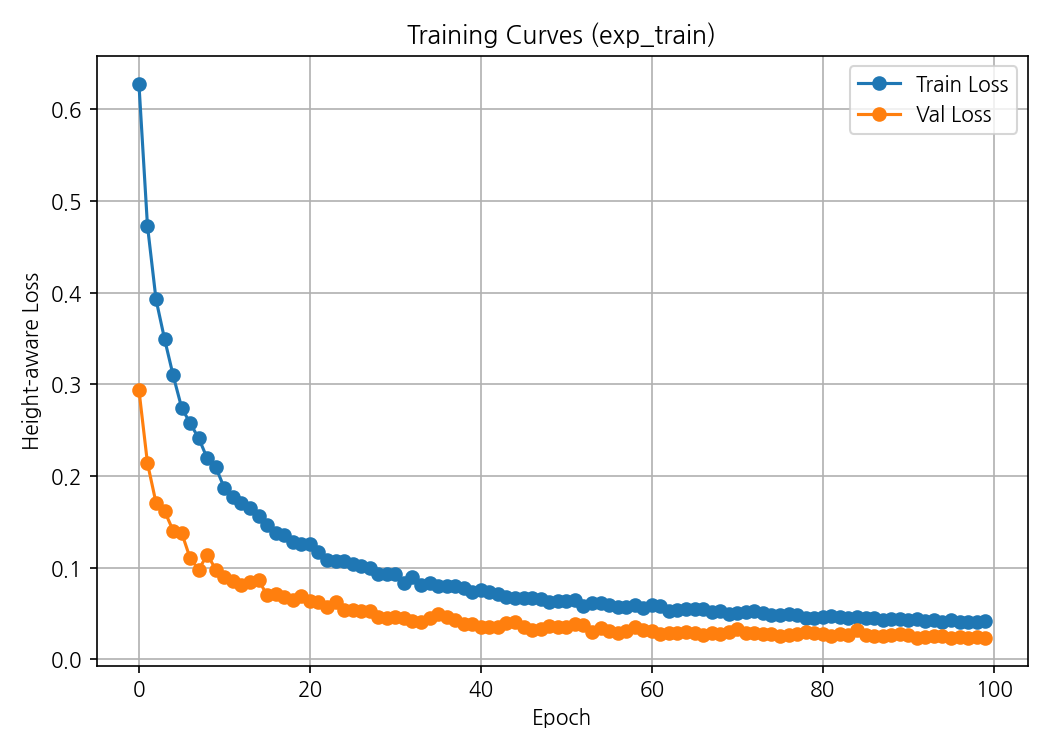

📊 exp_train_val_before.png


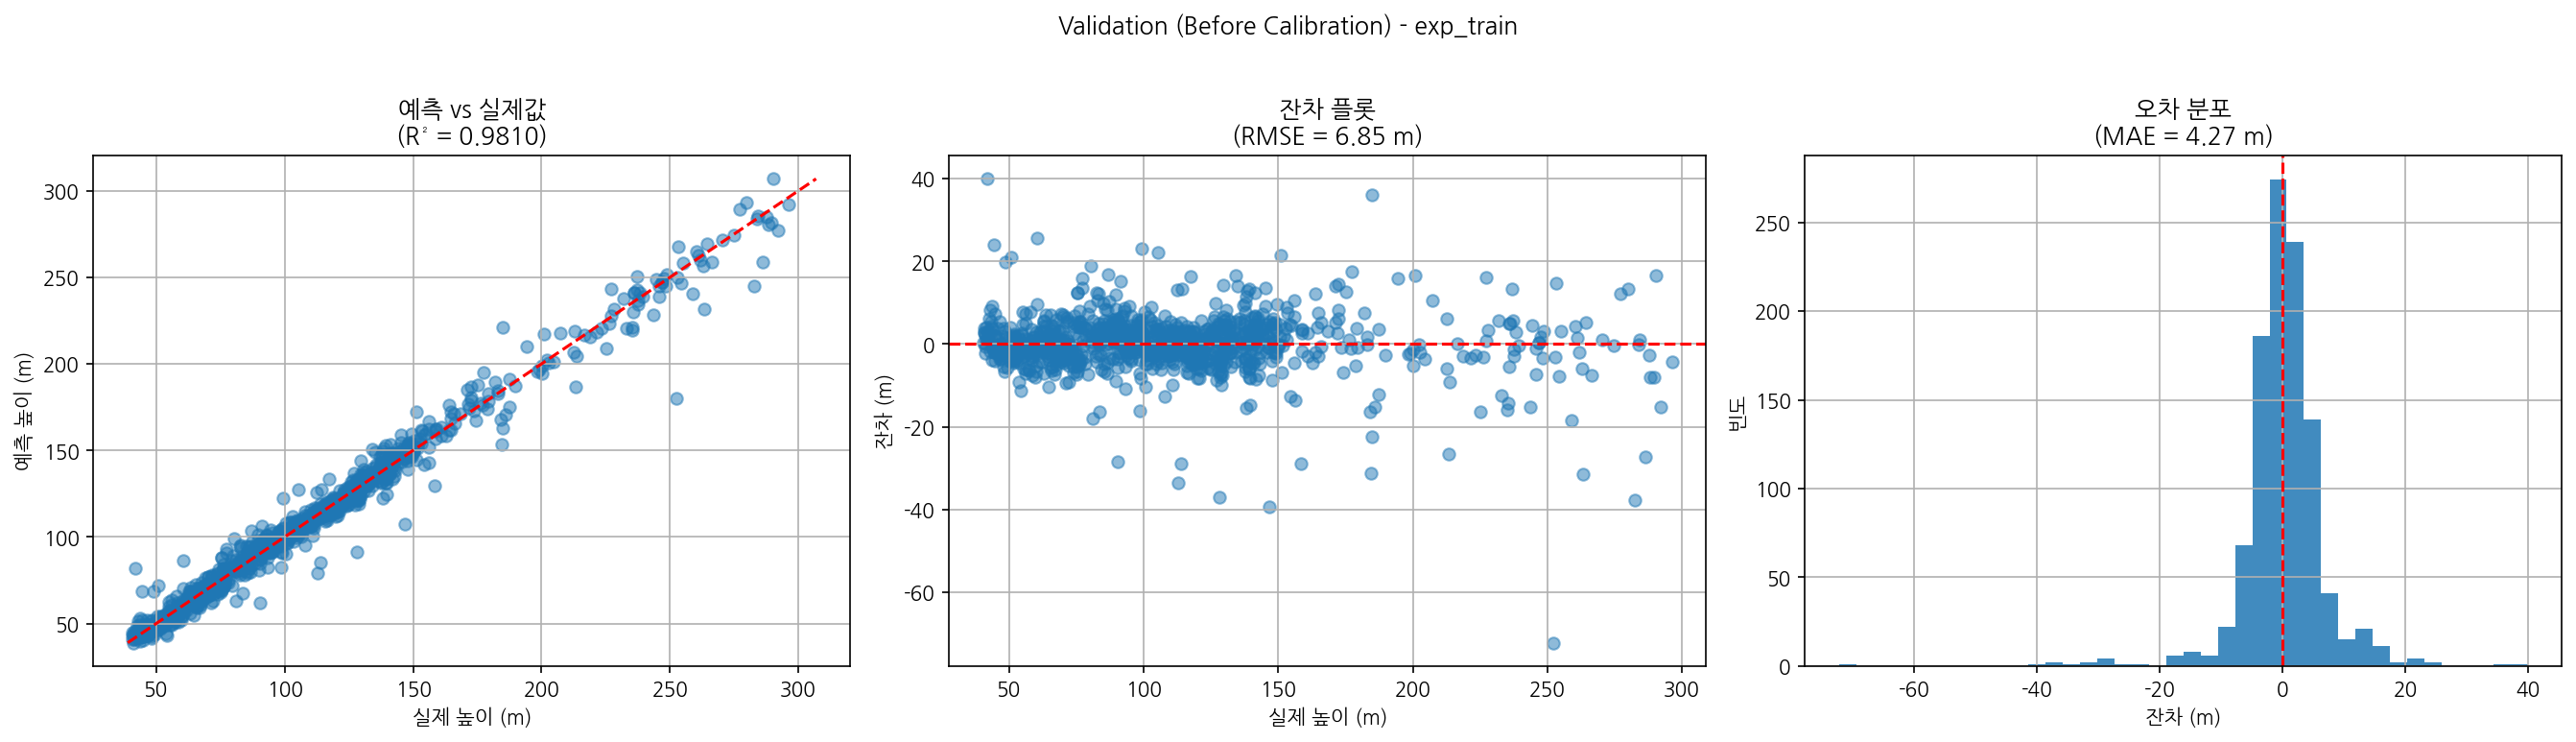

📊 exp_train_val_after.png


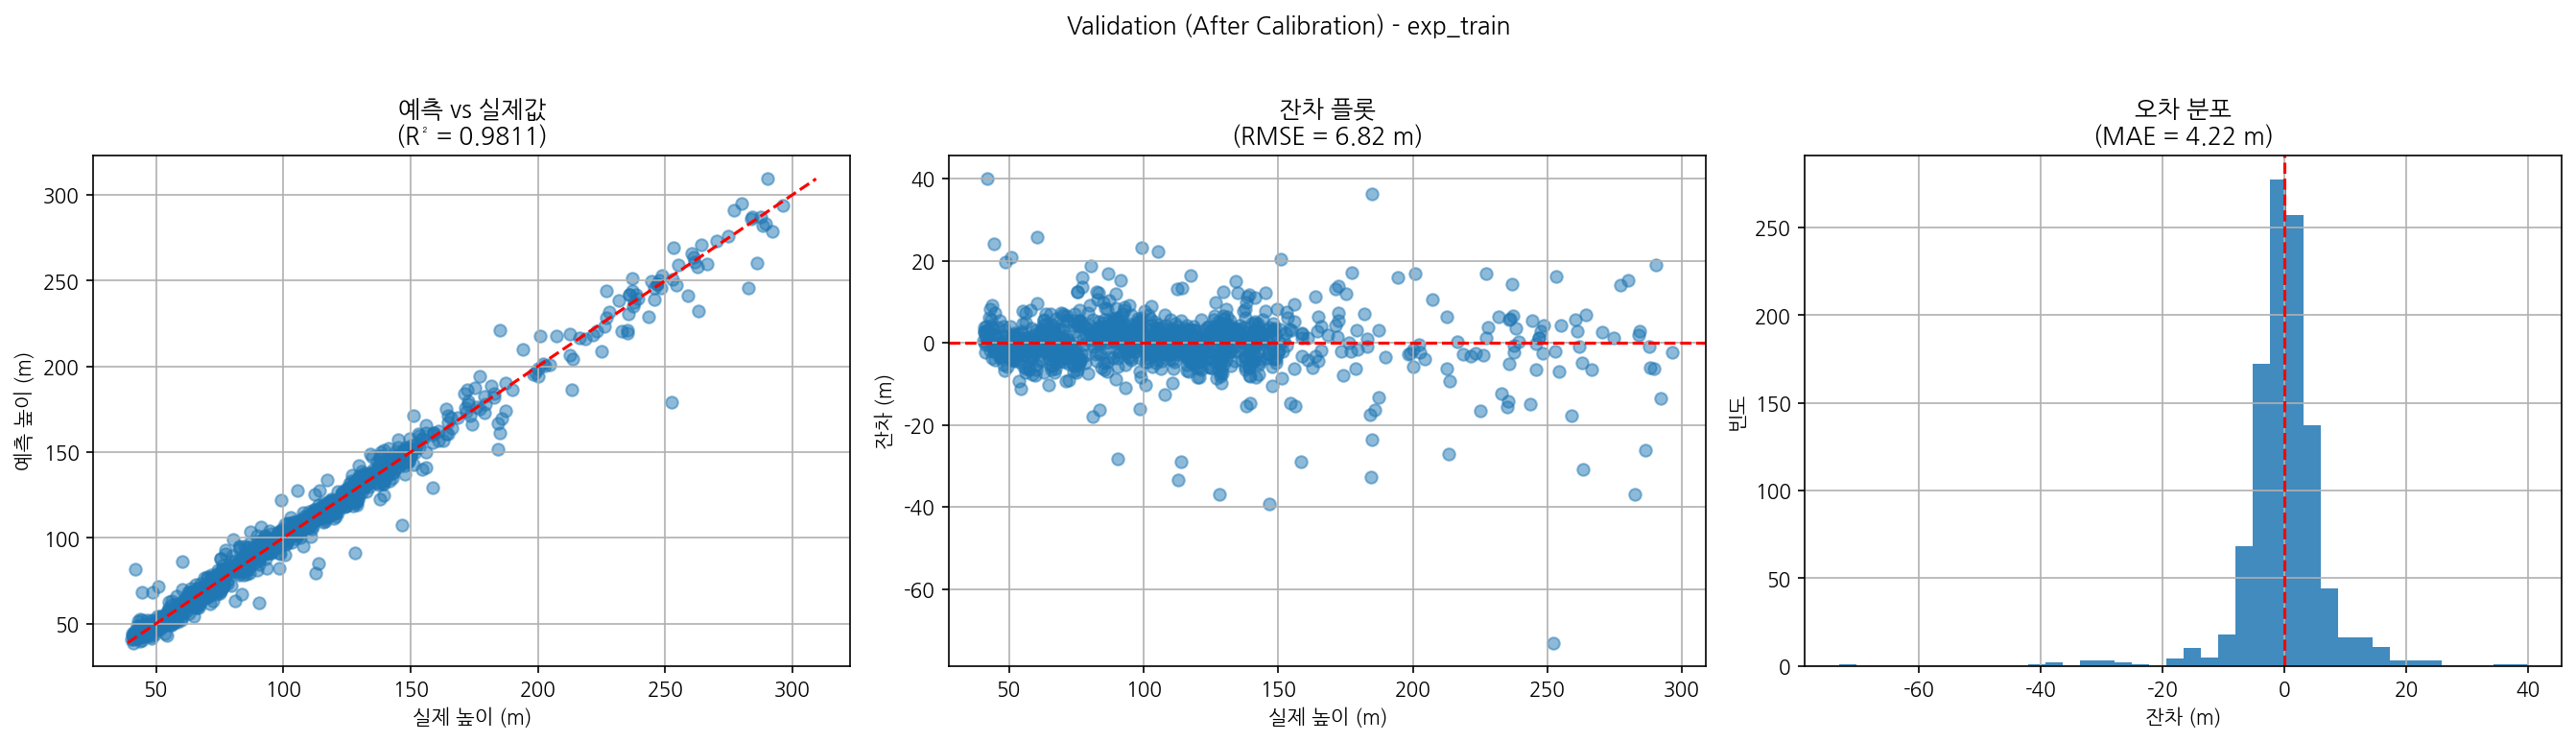

In [48]:
# === Step 2-1. 학습 결과 시각화 출력 (저장된 PNG 불러오기) ===
from IPython.display import Image, display
from pathlib import Path

FIGURES_DIR = Path("./figures")

# 표시할 이미지 리스트
plot_files = [
    "exp_train_training_curves.png",
    "exp_train_val_before.png",
    "exp_train_val_after.png"
]

print("=== 저장된 학습 시각화 결과 ===")
for fname in plot_files:
    fpath = FIGURES_DIR / fname
    if fpath.exists():
        print(f"{fname}")
        display(Image(filename=str(fpath), width=900))
    else:
        print(f"파일 없음: {fpath}")

In [44]:
# === Step 3. 추론 & 평가 ===
# 학습 파트에서 저장한 best checkpoint 경로 사용
best_ckpt = train_res["best_ckpt_path"]  # run_full_training이 반환

test_res = run_test_inference(
    train_label_csv=LABELS_TRAIN_CSV,
    test_label_csv=LABELS_TEST_CSV,
    checkpoint_path=best_ckpt,           # 또는 MODELS_DIR/'best.pth'
    figures_dir=FIGURES_DIR,
    apply_val_calibration=True,          # 검증셋에서 재추정한 보정 계수 Test에 적용(권장)
    q_calib=0.80,
    run_name="exp_test"
)

[Calib-Q0.8] Base RMSE=6.85m / MAE=4.27m
[Calib-Q0.8] H_TH=139.09m  a=1.026, b=-5.60
[Calib-Q0.8] Overall RMSE: 6.85m → 6.82m, MAE: 4.27m → 4.22m
[Test] Saved predictions: figures/exp_test_test_predictions.csv
[Test] Saved summary   : figures/exp_test_test_summary.json
[Test] Metrics (Before): {'RMSE_m': 6.4331735737266245, 'MAE_m': 4.1383007076664216, 'R2': 0.9827846269029062}
[Test] Metrics (After ): {'RMSE_m': 6.424551919496918, 'MAE_m': 4.111490153726446, 'R2': 0.9828307396135212}


In [45]:
print(test_res)

{'pred_csv': 'figures/exp_test_test_predictions.csv', 'summary_json': 'figures/exp_test_test_summary.json', 'metrics_before': {'RMSE_m': 6.4331735737266245, 'MAE_m': 4.1383007076664216, 'R2': 0.9827846269029062}, 'metrics_after': {'RMSE_m': 6.424551919496918, 'MAE_m': 4.111490153726446, 'R2': 0.9828307396135212}}



=== 테스트 결과 시각화 결과 ===
📈 exp_test_test_before.png


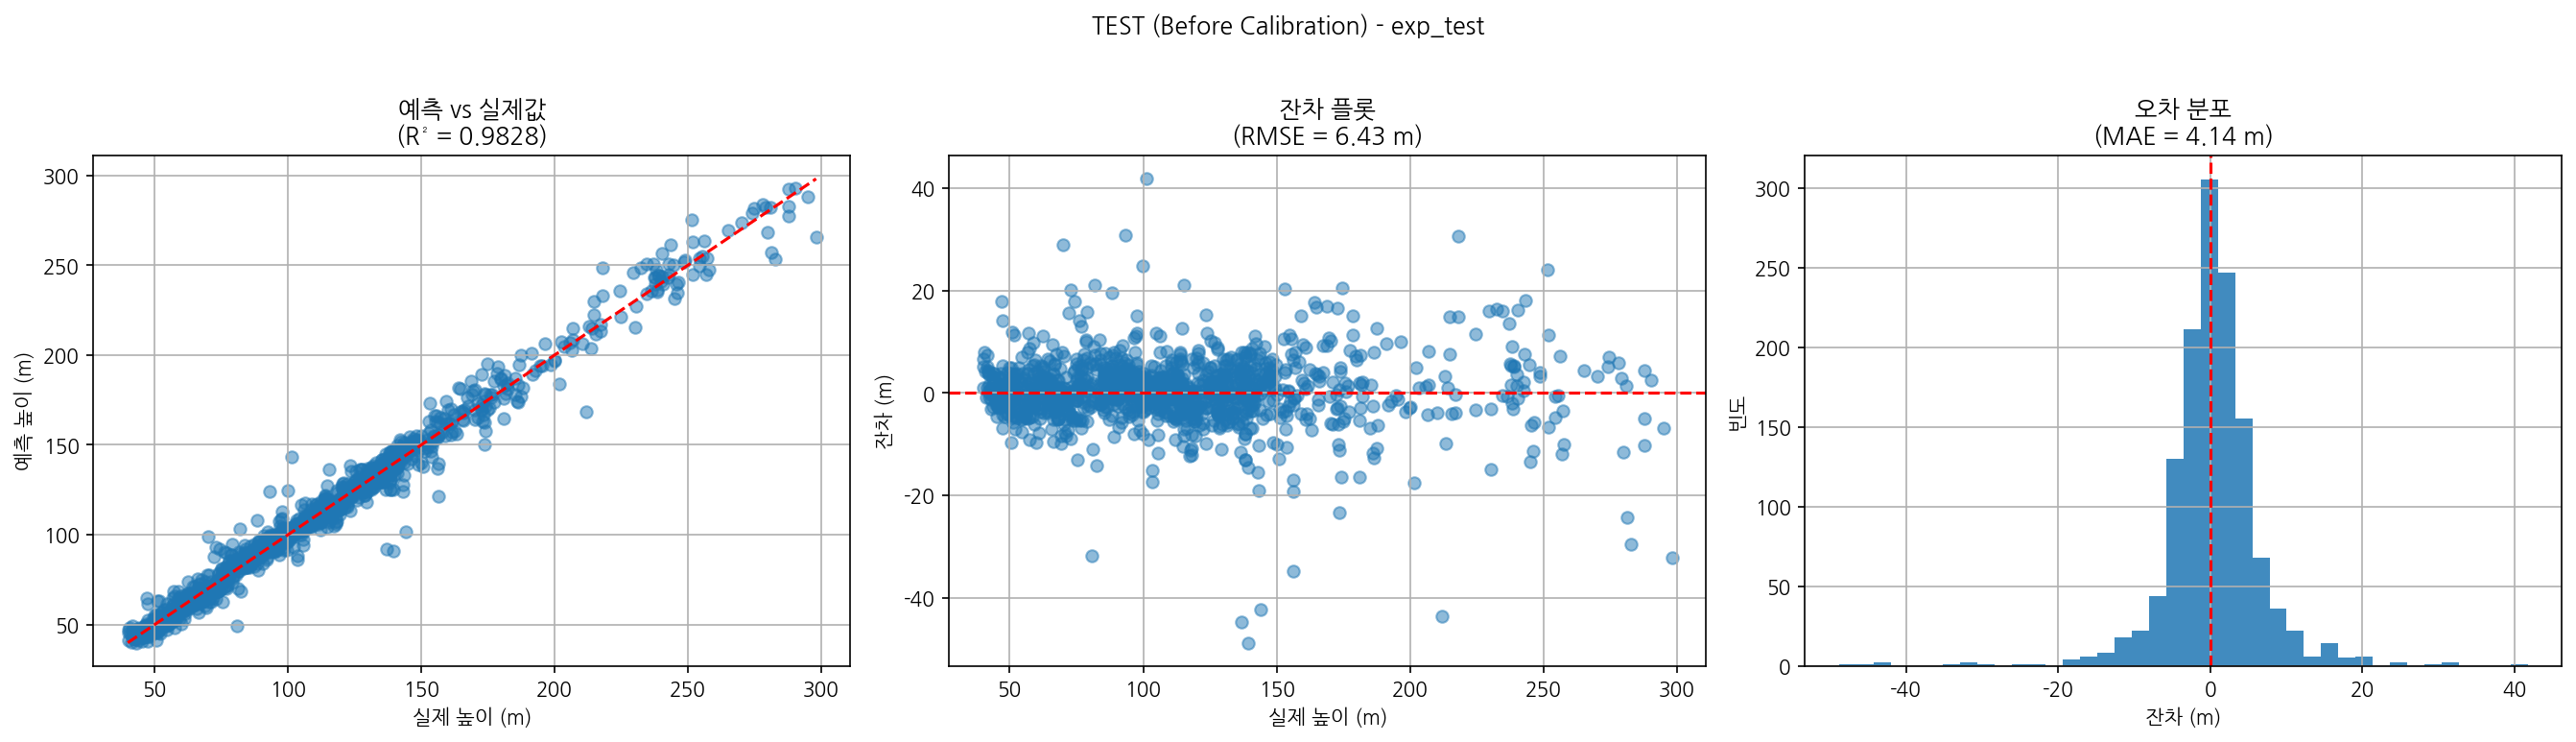

📈 exp_test_test_after.png


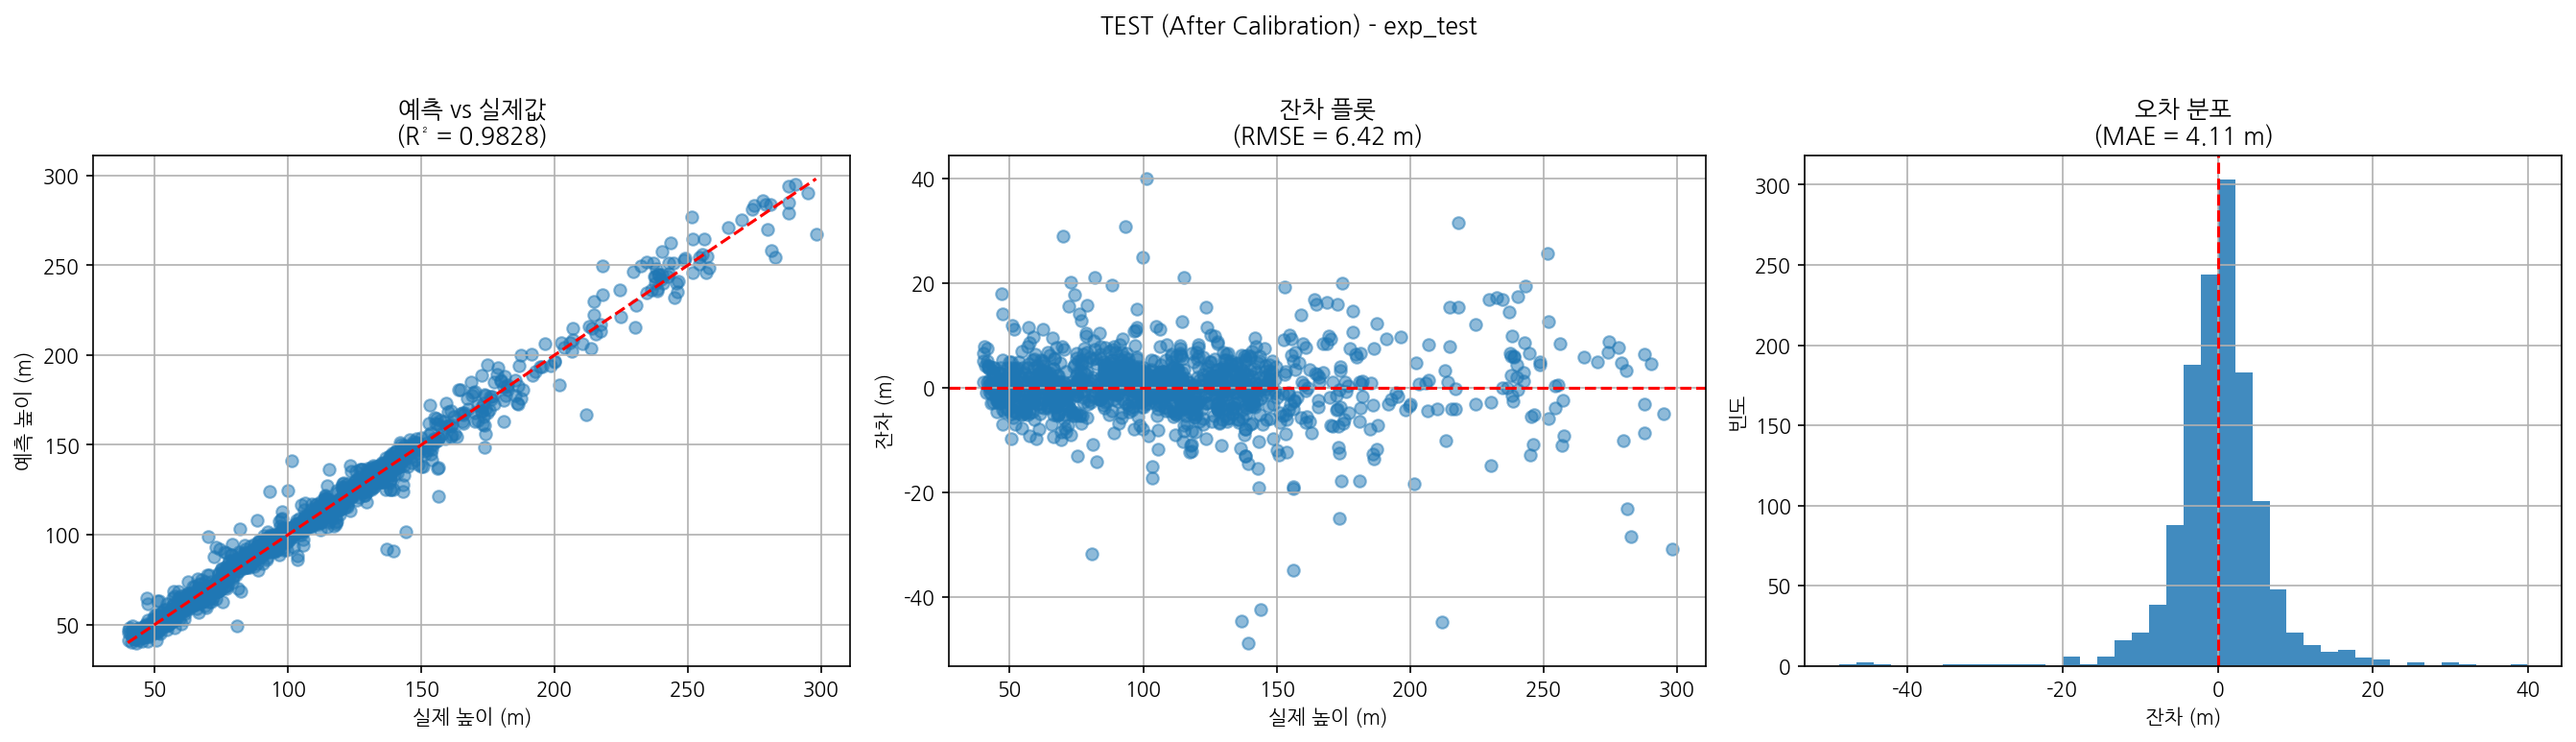

In [49]:
# === Step 3-1. 추론 결과 시각화 출력 (저장된 PNG 불러오기) ===
test_plot_files = [
    "exp_test_test_before.png",
    "exp_test_test_after.png"
]

print("\n=== 테스트 결과 시각화 결과 ===")
for fname in test_plot_files:
    fpath = FIGURES_DIR / fname
    if fpath.exists():
        print(f"{fname}")
        display(Image(filename=str(fpath), width=900))
    else:
        print(f"파일 없음: {fpath}")

In [52]:
!pip freeze > /content/drive/MyDrive/M2/requirements.txt
print("✅ requirements.txt saved to Drive/M2/")

✅ requirements.txt saved to Drive/M2/


In [53]:
# 현재 환경의 패키지 전체 목록을 requirements.txt로 저장
!pip freeze > requirements.txt